In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/train.csv')

In [3]:
from sklearn.linear_model import LogisticRegression, LinearRegression
import xgboost as xgb


X = data.drop(columns=['FloodProbability'])
y = data['FloodProbability']

'''
regression = LinearRegression()
regression.fit(X, y)
'''

xg_reg = xgb.XGBRegressor(objective="reg:linear", n_estimators=100, max_depth=10, seed=123)
xg_reg.fit(X,y)

regression = xg_reg

c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:17:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [9]:
from kan import KAN
import torch

ntrain = 50000
ntest = 1000
nfeat = 21

idxs_train = np.random.choice(X.shape[0], size=ntrain)
idxs_test = np.random.choice(X.shape[0], size=ntest)

Xtorch = torch.from_numpy(np.array(X))
ytorch = torch.from_numpy(np.array(y)[:,None])

dataset = {}
dataset['train_input'] = Xtorch[idxs_train,1:nfeat]
dataset['train_label'] = ytorch[idxs_train]
dataset['test_input'] = Xtorch[idxs_test,1:nfeat]
dataset['test_label'] = ytorch[idxs_test]

def train_err():
    return torch.mean((model(dataset['train_input'])[:,0] - dataset['train_label'][:,0]).float()**2)
def test_err():
    return torch.mean((model(dataset['test_input'])[:,0] - dataset['test_label'][:,0]).float()**2)

model = KAN(width=[nfeat-1,4,2,1], grid=3, k=3)
model.train(dataset, opt="LBFGS", steps=20, metrics=(train_err,test_err));

train loss: 1.98e-02 | test loss: 1.98e-02 | reg: 2.33e+01 : 100%|██| 20/20 [25:17<00:00, 75.88s/it]


In [27]:
y_pred = regression.predict(X)
np.mean((y_pred-y)**2)**0.5

0.020245535458096212

In [10]:
data_test = pd.read_csv('data/test.csv')

Xtesttorch = torch.from_numpy(np.array(data_test)[:,1:])
ytest = model(Xtesttorch)

In [11]:
import datetime
tail = datetime.datetime.now().strftime("%y_%m_%d-%H_%M_")

#data_test = pd.read_csv('data/test.csv')
y_test = ytest.detach().numpy()[:,0] # regression.predict(data_test)

dic = {'FloodProbability': y_test}
submission = pd.DataFrame.from_dict(dic)
submission.reset_index(drop=True, inplace=True)
submission['id'] = data_test['id']
submission.set_index('id', inplace=True)

submission.to_csv('data/my_submission_{}.csv'.format(tail))

In [38]:
model(dataset['test_input'])

tensor([[0.4526],
        [0.5753],
        [0.5413],
        ...,
        [0.4637],
        [0.4574],
        [0.5129]], grad_fn=<AddBackward0>)

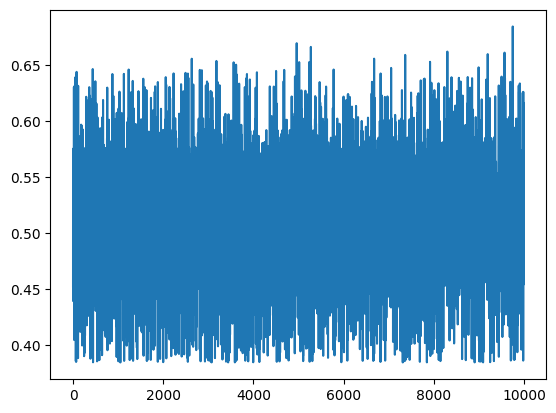

In [39]:
plt.plot(model(dataset['test_input']).detach().numpy())